# Lab 04: Wine Quality System

---
author: Yiran Hu
date: March 4th, 2024
embed-resources: true
---

## Introduction

In Lab 04, we are working on a project to create an AI Sommelier for our startup. The goal is to use chemistry equipment to analyze wines and then train a model to predict wine quality from these analyses. This involves looking at the wine's physicochemical data, such as acidity, sugar content, and alcohol level, which are important factors in determining its quality.

We will use the "Wine Quality" dataset from the UC Irvine Machine Learning Repository for this lab. This dataset includes both the quality ratings given by human sommeliers and the physicochemical properties of the wines. Our method employs the K-Nearest Neighbor (KNN) regression technique to predict wine quality. This lab is designed to simplify the selection of high-quality wines, using technology to replicate the skill and knowledge of expert sommeliers.

## Methods

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from joblib import dump

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# for visualization
import seaborn as sns
import matplotlib.pyplot as plt

### Data

In [97]:
wine_train = pd.read_csv("https://cs307.org/lab-04/data/wine-train.csv")

# create X and y for train
X_train = wine_train.drop("quality", axis=1)
y_train = wine_train["quality"]

The Wine Quality dataset utilized in Lab 04 of CS 307 is derived from a comprehensive study by Cortez et al. (2009), which aimed at modeling wine preferences based on their physicochemical properties. This dataset has since been recognized as a standard resource within the machine learning community, thanks in part to its inclusion in the UC Irvine Machine Learning Repository (UCI MLR). Originally consisting of two distinct datasets for red and white Portuguese "Vinho Verde" wines, the version for this lab combines them while introducing a color designation for each wine. Furthermore, the dataset has been preprocessed to include a train-test split, tailored specifically for the lab's requirements. This adaptation not only preserves the dataset's integrity for educational purposes but also enhances its applicability in exploring the nuances of wine quality assessment through data mining techniques.

In [98]:
wine_train

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,6.6,0.240,0.35,7.70,0.031,36.0,135.0,0.99380,3.19,0.37,10.5,5,white
1,8.3,0.280,0.48,2.10,0.093,6.0,12.0,0.99408,3.26,0.62,12.4,7,red
2,7.7,0.715,0.01,2.10,0.064,31.0,43.0,0.99371,3.41,0.57,11.8,6,red
3,5.2,0.370,0.33,1.20,0.028,13.0,81.0,0.99020,3.37,0.38,11.7,6,white
4,6.6,0.260,0.56,15.40,0.053,32.0,141.0,0.99810,3.11,0.49,9.3,5,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5192,7.6,0.320,0.58,16.75,0.050,43.0,163.0,0.99990,3.15,0.54,9.2,5,white
5193,5.6,0.280,0.27,3.90,0.043,52.0,158.0,0.99202,3.35,0.44,10.7,7,white
5194,6.4,0.370,0.20,5.60,0.117,61.0,183.0,0.99459,3.24,NaN,9.5,5,white
5195,6.5,0.260,0.50,NaN,0.051,46.0,197.0,0.99536,3.18,0.47,9.5,5,white


#### Summary Statistics

In [99]:
Quality_relationship1 = wine_train[['fixed acidity', 'volatile acidity', 'citric acid',
                                    'residual sugar', 'chlorides', 'quality']].groupby("quality").agg(["mean", "std"])
Quality_relationship1

fixed acidity           volatile acidity           citric acid  \
                 mean       std             mean       std        mean   
quality                                                                  
3            7.756522  1.726748         0.528125  0.368752    0.254091   
4            7.236478  1.222491         0.447428  0.219893    0.277593   
5            7.301881  1.245721         0.386187  0.174655    0.310171   
6            7.155267  1.270186         0.311335  0.145341    0.324112   
7            7.145218  1.400646         0.286337  0.116265    0.337491   
8            6.840667  1.156313         0.295064  0.118403    0.330205   
9            7.500000  1.116542         0.307500  0.061847    0.360000   

                  residual sugar           chlorides            
              std           mean       std      mean       std  
quality                                                         
3        0.165577       4.885417  4.521458  0.075750  0.054809  
4        0.181535       4.113580  3.838377  0.061017  0.051351  
5        0.160829       5.891244  5.025591  0.063546  0.040161  
6        0.140707       5.606834  4.959317  0.054249  0.031704  
7        0.112270       4.676773  4.047725  0.045678  0.022692  
8        0.106651       5.454605  4.207669  0.040720  0.015304  
9        0.066833       4.600000  4.160128  0.026250  0.008057

In [100]:
Quality_relationship2 = wine_train[['free sulfur dioxide', 'total sulfur dioxide', 'density',
                                    'pH', 'sulphates', 'alcohol', 'quality']].groupby("quality").agg(["mean", "std"])
Quality_relationship2

free sulfur dioxide            total sulfur dioxide             \
                       mean        std                 mean        std   
quality                                                                  
3                 33.782609  41.444055           104.229167  86.816896   
4                 19.508671  17.131118           103.459538  60.316015   
5                 30.649768  18.516104           121.954493  60.659587   
6                 31.080710  16.787990           115.075257  54.905256   
7                 30.691057  14.992278           107.489005  48.046896   
8                 33.929487  17.215939           116.296178  43.677246   
9                 34.000000  15.427249           116.750000  22.808989   

          density                  pH           sulphates            \
             mean       std      mean       std      mean       std   
quality                                                               
3        0.995682  0.002727  3.273913  0.224393  0.505217  0.134464   
4        0.994791  0.002493  3.224172  0.178871  0.500788  0.170247   
5        0.995836  0.002436  3.212058  0.154790  0.523742  0.142306   
6        0.994541  0.003072  3.216000  0.160769  0.531429  0.144186   
7        0.993124  0.002998  3.223486  0.157994  0.546919  0.162616   
8        0.992604  0.002990  3.221622  0.164516  0.516644  0.164955   
9        0.991750  0.003522  3.292500  0.086939  0.477500  0.102754   

           alcohol            
              mean       std  
quality                       
3        10.215909  1.099284  
4        10.196296  0.995402  
5         9.825121  0.791710  
6        10.596682  1.131358  
7        11.398151  1.192320  
8        11.611486  1.355238  
9        11.766667  1.184624

This code performs an analysis and summary of the relationship between wine quality and its physicochemical characteristics in a wine dataset. By grouping the wine samples based on their quality ratings, the variables Quality_relationship1 and Quality_relationship2 calculate the mean and standard deviation for various chemical properties across different quality levels. This statistical analysis helps to reveal which chemical attributes are significant indicators of wine quality.

#### Visualizations

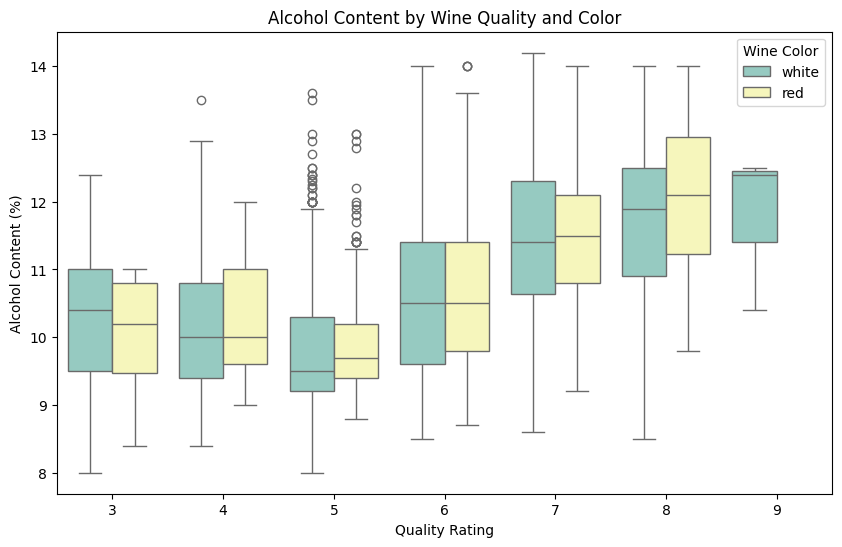

In [101]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='quality', y='alcohol', hue='color',
            data=wine_train, palette="Set3")
plt.title('Alcohol Content by Wine Quality and Color')
plt.xlabel('Quality Rating')
plt.ylabel('Alcohol Content (%)')
plt.legend(title='Wine Color')
plt.show()

The box plot visualizes the relationship between wine quality, alcohol content, and wine color. It shows the median, spread, and outliers of alcohol percentages for wines of different quality ratings, separated into red and white categories. This allows us to observe trends and differences in alcohol content across wine quality levels and between the two wine colors, providing insights into how these factors might be interconnected.

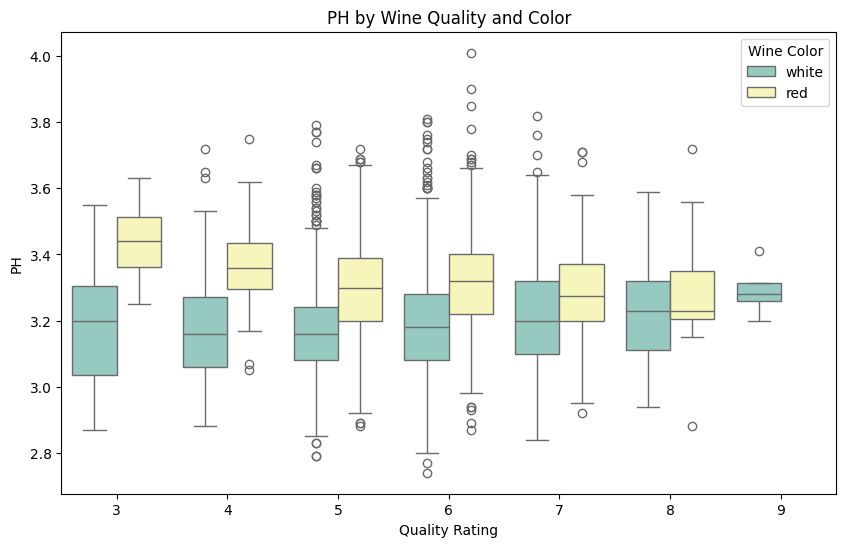

In [102]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='quality', y='pH', hue='color', data=wine_train, palette="Set3")
plt.title('PH by Wine Quality and Color')
plt.xlabel('Quality Rating')
plt.ylabel('PH')
plt.legend(title='Wine Color')
plt.show()

This box plot illustrates the relationship between wine quality and pH levels, categorized by wine color (red or white). The plot reveals that, across various quality ratings, red wines generally exhibit higher pH levels compared to white wines.

### Models

In [103]:
# find data types of X_train(12 features in total)
X_train.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
color                    object
dtype: object

In [104]:
# split the data into numerical and categorical
numeric_features = X_train.select_dtypes(include=["float64"]).columns
categorical_features = X_train.select_dtypes(include=["object"]).columns

In this lab, I processed a dataset with 12 features, comprising both numerical and categorical data. I applied one-hot encoding to transform categorical variables into a binary format, making them suitable for use in the model. For numerical features, I used imputation to handle missing values and standardization to normalize their scales.

In [105]:
# define how to handle missing data and scale features for numeric and categorical features
numeric_transformer = Pipeline(
    steps=[
        ("Iterative Imputer", IterativeImputer(estimator=LinearRegression())),
        ("Standardization", StandardScaler()),
    ]
)
categorical_transformer = Pipeline(
    steps=[
        ("Modal Imputer", SimpleImputer(strategy="most_frequent")),
        ("One-Hot Encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

In [106]:
# create general preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("Numeric Transformer", numeric_transformer, numeric_features),
        ("Categorical Transformer", categorical_transformer, categorical_features),
    ],
    remainder="drop",
)

I chose the K-Nearest Neighbors (KNN) model for prediction, due to its effectiveness in handling complex patterns. To optimize the model, I conducted hyperparameter tuning through grid search, focusing on the number of neighbors, weight strategies, and distance metrics.

In [107]:
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('polynomialfeatures', PolynomialFeatures()),
                                 ('regressor', KNeighborsRegressor())])

In [108]:
param_grid = {
    "regressor__n_neighbors": range(1, 30),  # set the range of k
    # define how the neighbors contribute, equally or have different weights based on distance
    "regressor__weights": ["uniform", "distance"],
    # distance metrics to be used for calculating the proximity between data points
    "regressor__metric": ["euclidean", "manhattan", "chebyshev"]
}

In [109]:
# setup grid search with cross-validation
grid_search = GridSearchCV(model_pipeline, param_grid,
                           cv=10, scoring="neg_mean_absolute_error", n_jobs=-1, verbose=3)

In [110]:
# fit models
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 174 candidates, totalling 1740 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('Numeric '
                                                                         'Transformer',
                                                                         Pipeline(steps=[('Iterative '
                                                                                          'Imputer',
                                                                                          IterativeImputer(estimator=LinearRegression())),
                                                                                         ('Standardization',
                                                                                          StandardScaler())]),
                                                                         Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total s...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['color'], dtype='object'))])),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('regressor', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'regressor__metric': ['euclidean', 'manhattan',
                                               'chebyshev'],
                         'regressor__n_neighbors': range(1, 30),
                         'regressor__weights': ['uniform', 'distance']},
             scoring='neg_mean_absolute_error', verbose=3)

In [111]:
# save models
dump(grid_search, "wine-quality.joblib")

['wine-quality.joblib']

## Results

In [112]:
print("Best parameters found:", grid_search.best_params_)
print("Lowest MAE found:", np.sqrt(-grid_search.best_score_))

Best parameters found: {'regressor__metric': 'manhattan', 'regressor__n_neighbors': 5, 'regressor__weights': 'distance'}
Lowest MAE found: 0.6641628019583152


To ensure the model's robustness, I changed cross-validation (CV) to evaluate its performance on unseen data, ultimately selecting a configuration (cv=10, use "manhattan" method to calculate distances, each neighbor has weight based on the distance, and choose k=5) that demonstrated a good model performance. This approach allowed me to develop a reliable model for predicting wine quality based on its physicochemical properties.

## Discussion

The cost of chemistry equipment and the processes involved must be weighed against the value of the nuanced insights and personal recommendations a human sommelier provides. While AI can significantly augment and streamline certain aspects of wine selection, particularly those based on physicochemical properties, it is unlikely to fully replace the breadth of expertise, personal touch, and contextual advice offered by human sommeliers. The integration of AI should be seen as a complementary tool, enhancing rather than replacing the sommelier's role in the wine industry.

When using machine learning models like K-Nearest Neighbors (KNN) for predicting wine quality, which is represented by integer values in the dataset, the predictions might not always align as integers. However, this discrepancy does not necessarily pose a significant problem. The fractional part of the prediction can be interpreted as the model's confidence or inclination towards a particular quality rating. For instance, a predicted quality of 5.7 could suggest that the wine is better than the average quality level of 5 but not quite reaching the standard of 6, indicating a tendency or partial alignment with a higher quality bracket. This nuanced output provides additional insights into the predictive model's evaluation process, offering a more detailed understanding of where the wine stands in terms of quality. 

### Conclusion

In conclusion, this lab demonstrated the effective application of machine learning techniques, specifically the K-Nearest Neighbors (KNN) algorithm, enhanced through the use of advanced sklearn tools such as Pipeline and GridSearchCV, to predict wine quality from physicochemical properties. The resulting model, as indicated by the Mean Absolute Error (MAE) metric, shows promising potential for real-world applications, suggesting it can provide valuable insights into wine quality assessment. While the model exhibits the capacity for further improvement with additional training and fine-tuning, it is important to acknowledge its limitations. It cannot fully replicate the depth of knowledge and nuanced understanding possessed by experienced human experts in the field. Thus, while this AI-driven approach can significantly aid in the process of wine quality evaluation, it should be viewed as a complement to, rather than a replacement for, the expertise of professional sommeliers.